<a href="https://www.kaggle.com/code/alsayedhamdy/text-clustering-and-feature-engineering?scriptVersionId=107589056" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# **Importing Libraries**

In [1]:
#Importing libraries
import numpy as np
from numpy import unique
from numpy import where
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from wordcloud import WordCloud
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ParameterGrid
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.model_selection import GridSearchCV
from sklearn import model_selection, metrics, preprocessing, ensemble, model_selection, metrics
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import cross_val_score
from hyperopt import tpe, hp, fmin, STATUS_OK,Trials
from hyperopt.pyll.base import scope
import nltk
import time
import re
import string
from kmeanstf import KMeansTF
from nltk.tokenize import word_tokenize 
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from string import punctuation
from gensim.utils import tokenize

In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# **Data editing and understanding**

**Upload and understand the data**

In [3]:
df = pd.read_csv('../input/indiegogo/Indiegogo.csv')
df

,bullet_point,category,category_url,clickthrough_url,close_date,currency,funds_raised_amount,funds_raised_percent,image_url,is_indemand,...,perks_claimed,price_offered,price_retail,product_stage,project_id,project_type,source_url,tagline,tags,title
0,NaN,Wellness,/explore/wellness,/projects/help-paleo-fx-continue-to-change-lives,2022-06-18T23:59:59-07:00,USD,1810,0.006033,https://c1.iggcdn.com/indiegogo-media-prod-cld...,False,...,NaN,NaN,NaN,NaN,2750564,campaign,https://www.indiegogo.com/explore/all?project_...,Paleo f(x)™ is the world's largest Paleo healt...,"[""community"",""social innovations"",""speakers""]",Help Paleo FX continue to change lives!
1,NaN,Wellness,/explore/wellness,/projects/art-retreat-center-in-hokkaido-s-forest,2022-08-05T23:59:59-07:00,JPY,40000,0.011429,https://c1.iggcdn.com/indiegogo-media-prod-cld...,False,...,NaN,NaN,NaN,NaN,2759127,campaign,https://www.indiegogo.com/explore/all?project_...,Help us finish building our dome center for ar...,"[""community"",""kids"",""family""]",Art & Retreat Center in Hokkaido's forest
2,NaN,Wellness,/explore/wellness,/projects/christian-karate-club-dojo-1-year-fu...,2022-07-08T23:59:59-07:00,USD,310,0.023846,https://c1.iggcdn.com/indiegogo-media-prod-cld...,False,...,NaN,NaN,NaN,NaN,2761577,campaign,https://www.indiegogo.com/explore/all?project_...,We are growing faster than our current buildin...,"[""community"",""family"",""first-time founders"",""k...",Christian Karate Club Dojo - 1 year Funding
3,NaN,Wellness,/explore/wellness,/projects/new-beginnings-journal-by-omayra-jim...,2022-06-02T23:59:59-07:00,USD,4291,0.852400,https://c1.iggcdn.com/indiegogo-media-prod-cld...,True,...,NaN,NaN,NaN,NaN,2733665,campaign,https://www.indiegogo.com/explore/all?project_...,The New Beginnings Journaling Project,"[""books"",""first-time founders"",""female founder...",New Beginnings Journal by Omayra Jimenez
4,NaN,Wellness,/explore/wellness,/projects/from-grief-to-gratitude-coaching-cer...,2022-05-23T23:59:59-07:00,USD,740,0.303777,https://c1.iggcdn.com/indiegogo-media-prod-cld...,False,...,NaN,NaN,NaN,NaN,2748978,campaign,https://www.indiegogo.com/explore/all?project_...,Your Donation will go toward my Grief Coach Ce...,"[""community"",""founders of color"",""other""]",From 'Grief to Gratitude' Coaching Certification
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32316,NaN,Food & Beverages,/explore/food-beverages,/projects/the-farmstand-market-cafe,2017-04-16T23:59:59-07:00,USD,1096,0.146133,https://c1.iggcdn.com/indiegogo-media-prod-cld...,False,...,NaN,NaN,NaN,NaN,2054253,campaign,https://www.indiegogo.com/explore/all?project_...,Help The Farmstand Market and Cafe put down ne...,"[""other""]",The Farmstand Market & Cafe
32317,NaN,Food & Beverages,/explore/food-beverages,/projects/hopwins-brewery-and-craft-beer,2017-12-17T23:59:59-08:00,USD,7800,0.222857,https://c1.iggcdn.com/indiegogo-media-prod-cld...,False,...,NaN,NaN,NaN,NaN,2018156,campaign,https://www.indiegogo.com/explore/all?project_...,Perks 1 chip=1 beer 2 chips=Flight or Pint Gla...,"[""beer"",""beer"",""beer""]",HopWins Brewery and Craft Beer
32318,NaN,Food & Beverages,/explore/food-beverages,/projects/natureljuicing-organic-juicery-lounge,2018-04-02T23:59:59-07:00,USD,190,0.004419,https://c1.iggcdn.com/indiegogo-media-prod-cld...,False,...,NaN,NaN,NaN,NaN,2231967,campaign,https://www.indiegogo.com/explore/all?project_...,"Cold Pressed Juices, Smoothies + Eats FREE of ...","[""restaurant"",""restaurant""]",NaturelJuicing: Organic Juicery Lounge
32319,NaN,Food & Beverages,/explore/food-beverages,/projects/eluvium-brewing-company,2017-09-17T23:59:59-07:00,USD,5408,0.540800,https://c1.iggcdn.com/indiegogo-media-prod-cld...,False,...,NaN,NaN,NaN,NaN,2191110,campaign,https://www.indiegogo.com/explore/all?project_...,A small craft brewery dedicated to producing h...,"[""beer"",""beer""]",Eluvium Brewing Company


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32321 entries, 0 to 32320
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bullet_point          247 non-null    object 
 1   category              32321 non-null  object 
 2   category_url          32321 non-null  object 
 3   clickthrough_url      32321 non-null  object 
 4   close_date            32082 non-null  object 
 5   currency              32321 non-null  object 
 6   funds_raised_amount   32321 non-null  int64  
 7   funds_raised_percent  32321 non-null  float64
 8   image_url             32321 non-null  object 
 9   is_indemand           32321 non-null  bool   
 10  is_pre_launch         32321 non-null  bool   
 11  is_proven             32321 non-null  bool   
 12  offered_by            0 non-null      float64
 13  open_date             32072 non-null  object 
 14  perk_goal_percentage  10 non-null     float64
 15  perks_claimed      

1.   **I will ignore all the features except the feature ('title')**
2.   **And I will decrease the number of raws as well so the data won't be so huge**

In [5]:
df = df.drop(range(15100, 32321))
df = df.drop(df.loc[:, 'bullet_point':'tags'].columns, axis=1)
df

,title
0,Help Paleo FX continue to change lives!
1,Art & Retreat Center in Hokkaido's forest
2,Christian Karate Club Dojo - 1 year Funding
3,New Beginnings Journal by Omayra Jimenez
4,From 'Grief to Gratitude' Coaching Certification
...,...
15095,ALMOST - Mini Series
15096,FilipiNow: Filipino Content With A Cause
15097,Paradigm Pro Wrestling - The Paradigm Shift
15098,Craig Tries: The Web Series


**Now I will look for the missing values and clear it**

In [6]:
df.describe()

,title
count,15095
unique,15050
top,Untitled Draft Campaign
freq,9


In [7]:
df.isna().sum()

title    5
dtype: int64

In [8]:
df = df.dropna()

In [9]:
df.isna().sum()

title    0
dtype: int64

In [10]:
#Reset the index so it won't be any confusion
df.reset_index(inplace=True)
df

,index,title
0,0,Help Paleo FX continue to change lives!
1,1,Art & Retreat Center in Hokkaido's forest
2,2,Christian Karate Club Dojo - 1 year Funding
3,3,New Beginnings Journal by Omayra Jimenez
4,4,From 'Grief to Gratitude' Coaching Certification
...,...,...
15090,15095,ALMOST - Mini Series
15091,15096,FilipiNow: Filipino Content With A Cause
15092,15097,Paradigm Pro Wrestling - The Paradigm Shift
15093,15098,Craig Tries: The Web Series


# **Data preprocessing and feature engineering**

In [11]:
X = df['title']

**Now I will clean the text and do the data preprocessing**

In [12]:
stop_words = set(stopwords.words('english'))
ps = SnowballStemmer('english')
#Let's make a function to finish all the cleaning process
def clean_data(text):
    #Removing URLs
    text = re.sub('http\S+\s*', ' ', text)
    #Removing RT and cc
    text = re.sub('RT|cc', ' ', text)
    #Removing digits
    text = re.sub(r'\d+', '', text)
    #Removing hashtags
    text = re.sub('#\S+', '', text)
    #Removing mentions and E-mails
    text = re.sub('@\S+', '  ', text) 
    #Removing punctuations
    text = re.sub('[%s]' % re.escape("""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"""), ' ', text) 
    #Replacing non-ASCII characters with a single space
    text = re.sub(r'[^\x00-\x7f]',r' ', text) 
    #Removing extra whitespace
    text = re.sub('\s+', ' ', text)
    #Making the text in lowercase
    text = "".join([char.lower() for char in text if char not in string.punctuation])
    #Removing stopwords
    text = " ".join([word for word in str(text).split() if word not in stop_words])
    #Stemming
    text = " ".join([ps.stem(word) for word in text.split()])
    return text

#And now let's apply this function to our text
X = X.apply(lambda x: clean_data(x))
X

0           help paleo fx continu chang live
1         art retreat center hokkaido forest
2        christian karat club dojo year fund
3           new begin journal omayra jimenez
4                grief gratitud coach certif
                        ...                 
15090                       almost mini seri
15091        filipinow filipino content caus
15092     paradigm pro wrestl paradigm shift
15093                     craig tri web seri
15094            reveng club concept trailer
Name: title, Length: 15095, dtype: object

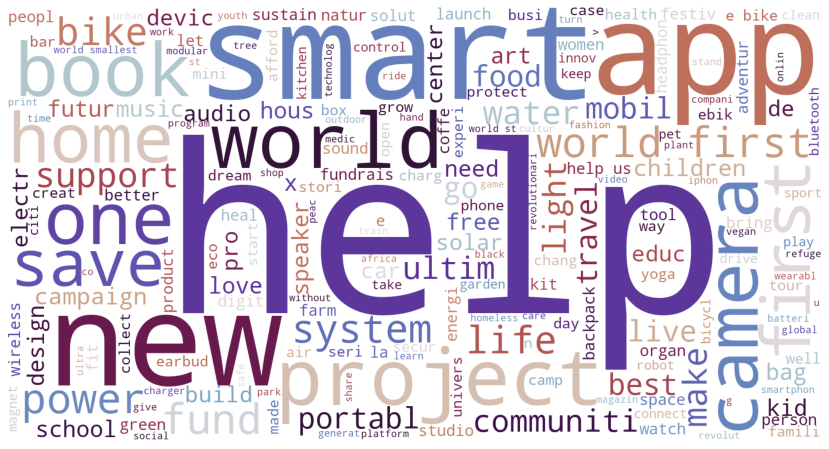

In [13]:
#Now the text is clean!
wordcloud = WordCloud(background_color='white', 
                      max_words=200,
                      width=1500, 
                      height=800, colormap='twilight').generate(' '.join(X))

plt.figure(figsize=(32,8))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

**Now to the feature engineering part**

*   **What is TF-IDF and why we use it?**
---
📌 Term frequency-inverse document frequency. 
Machine learning algorithms often use numerical data, so when dealing with textual data or any natural language processing (NLP) task, a sub-field of ML/AI dealing with text, that data first needs to be converted to a vector of numerical data by a process known as vectorization. TF-IDF vectorization involves calculating the TF-IDF score for every word in your corpus relative to that document and then putting that information into a vector (see image below using example documents “A” and “B”). Thus each document in your corpus would have its own vector, and the vector would have a TF-IDF score for every single word in the entire collection of documents. Once you have these vectors you can apply them to various use cases such as seeing if two documents are similar by comparing their TF-IDF vector using cosine similarity.

*   **What is PCA and why we use it?**

---
📌 Principal component analysis. Principal component analysis, or PCA, is a dimensionality-reduction method that is often used to reduce the dimensionality of large data sets, by transforming a large set of variables into a smaller one that still contains most of the information in the large set.

Reducing the number of variables of a data set naturally comes at the expense of accuracy, but the trick in dimensionality reduction is to trade a little accuracy for simplicity. Because smaller data sets are easier to explore and visualize and make analyzing data much easier and faster for machine learning algorithms without extraneous variables to process.

So, to sum up, the idea of PCA is simple — reduce the number of variables of a data set, while preserving as much information as possible.
Why we use it?

1.   Standardize the range of continuous initial variables
2.   Compute the covariance matrix to identify correlations
3.   Compute the eigenvectors and eigenvalues of the covariance matrix to identify the principal components
4.   Create a feature vector to decide which principal components to keep
Recast the data along the principal components axes










In [14]:
#I used the TFIDF vectorizer to vectorize my text
tfidf_vec = TfidfVectorizer(min_df=0.005, max_features=5000) 
data_tfidf = tfidf_vec.fit_transform(X).todense()

#And now I will use the PCA 
pca = PCA( 0.95, random_state=42)
data_pca = pca.fit_transform(data_tfidf)

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


In [15]:
#We need to check the shape of our array
print( f"TF-IDF dimension - {data_tfidf.shape[1]}" )
print( f"TF-IDF + PCA dimension - {data_pca.shape[1]}" )

TF-IDF dimension - 105
TF-IDF + PCA dimension - 96


In [16]:
#Now I will identify the number of words so I can get the features and make all the featuers equal and the same dimesion
N_WORDS = 30
mean_data_tfidf = np.array(data_tfidf.mean(axis=0)).flatten()
vocabulary = tfidf_vec.get_feature_names()
words_id = np.flip( mean_data_tfidf.argsort()[-N_WORDS:] )

#Now let's build our features dataframe
word_val_data = [(vocabulary[id], mean_data_tfidf[id]) for id in words_id]
word_val_data = pd.DataFrame(word_val_data, columns=['words','values'])

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


# **3- (5 points)**

**I will use the KMeans algorithm**

**K-Means Clustering**

---


K-means clustering is the most commonly used unsupervised machine learning algorithm for partitioning a given data set into a set of k groups (i.e. k clusters), where k represents the number of groups pre-specified by the analyst. It classifies objects in multiple groups (i.e., clusters), such that objects within the same cluster are as similar as possible (i.e., high intra-class similarity), whereas objects from different clusters are as dissimilar as possible (i.e., low inter-class similarity). In k-means clustering, each cluster is represented by its center (i.e, centroid) which corresponds to the mean of points assigned to the cluster.


---


**The Basic Idea**

---


The basic idea behind k-means clustering consists of defining clusters so that the total intra-cluster variation (known as total within-cluster variation) is minimized. There are several k-means algorithms available. The standard algorithm is the Hartigan-Wong algorithm (1979), which defines the total within-cluster variation as the sum of squared distances Euclidean distances between items and the corresponding centroid:
![k-means-objective-function.png](https://www.researchgate.net/profile/Mahesh-Sarathchandra/publication/344888655/figure/fig1/AS:950914114408448@1603727000307/k-means-objective-function.ppm)

# **Modeling**

**Now I will explain my Hyper-parameters and why did I choose them**



*   n_init

---
In K-means the initial placement of centroid plays a very important role in it's convergence. Sometimes, the initial centroids are placed in a such a way that during consecutive iterations of K-means the clusters the clusters keep on changing drastically and even before the convergence condition may occur, max_iter is reached and we are left with incorrect cluster. Hence, the clusters obtained in such may not be correct. To overcome this problem, this parameter is introduced. The value of n_iter basically determines how many different sets of randomly chosen centroids, should the algorithm use. For each different set of points, a comparision is made about how much distance did the clusters move, i.e. if the clusters travelled small distances than it is highly likely that we are closest to ground truth/best solution. The points which provide the best performance and their respective run along with all the cluster labels are returned.

**And because our clusers will be a little huge becase the data is huge so I choosed 30 as initial placement of centroid**



*   n_clusters

---

**I will use a way to tune the number of clusters and then we will know what is the most optimal number of clusters we shall use.**



In [17]:
#So let's tune between the range 90 - 105
cluster_sizes = range(90, 105)
kmeans_models = [KMeansTF(i, n_init=30) for i in cluster_sizes]
cluster_score = []

for kmeans in kmeans_models:
  y = kmeans.fit_predict(data_pca)
  score = silhouette_score(data_pca, y)
  cluster_score.append((kmeans.n_clusters, score))

cluster_score=np.array(cluster_score)

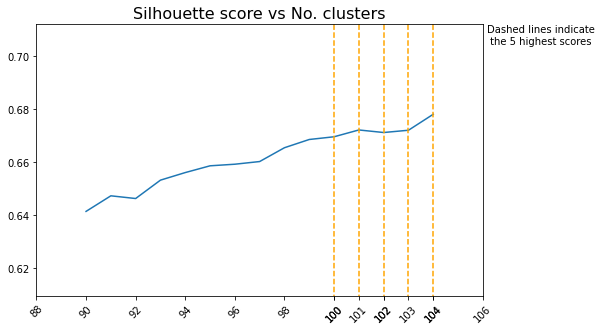

In [18]:

scores = cluster_score[:, 1]
clusters = cluster_score[:, 0]
max_score_clusters = []

fig, ax = plt.subplots(figsize=(8,5))
ax = sns.lineplot(x=clusters, y=scores, ax=ax)
ax.set_title("Silhouette score vs No. clusters", fontsize=16)

for i in np.argsort(scores)[-5:]:
  ax.vlines(clusters[i], 0, 1, linestyles='--', colors='orange')
  max_score_clusters.append(clusters[i])

ax.text(1.01, 1, f"Dashed lines indicate\n the {len(max_score_clusters)} highest scores",
        transform=ax.transAxes, ha='left', va='top')

xticks = ax.get_xticks().astype(int)
xticks = np.append(xticks, max_score_clusters)
ax.set_xticks( xticks )
ax.tick_params(axis='x', rotation=45)

ax.set_ylim([0.95*min(scores), 1.05*max(scores)])
ax.set_xlim()

plt.show()

**So as we see the optimal number of clusters will be 103**

**Now let's go and apply it to our data**

In [19]:
n_clusters = 103
kmeans_model = KMeans(n_clusters, n_init=30)
y = kmeans_model.fit_predict(data_pca)

# **Clustering score and visualization**

In [20]:
#Now let's see a sample of our result
sample_scores = silhouette_samples( data_pca, y )
sample_scores_df =  pd.DataFrame( data = {'Cluster':y, 'Silhouette':sample_scores} )
sample_scores_df = sample_scores_df.reset_index()
sample_scores_df=sample_scores_df.sort_values('Silhouette', ascending=False)
sample_scores_df

,index,Cluster,Silhouette
1980,1980,1,0.996412
513,513,1,0.996412
12490,12490,1,0.996412
2485,2485,1,0.996412
2066,2066,1,0.996412
...,...,...,...
3053,3053,76,-0.114402
9518,9518,77,-0.120753
6729,6729,73,-0.123293
2346,2346,100,-0.142180


**Let's visualize the clustering results**

<AxesSubplot:title={'center':'The silhouette score plot for the 103 clusters.\n'}, xlabel='Silhouette coefficient values', ylabel='Cluster'>

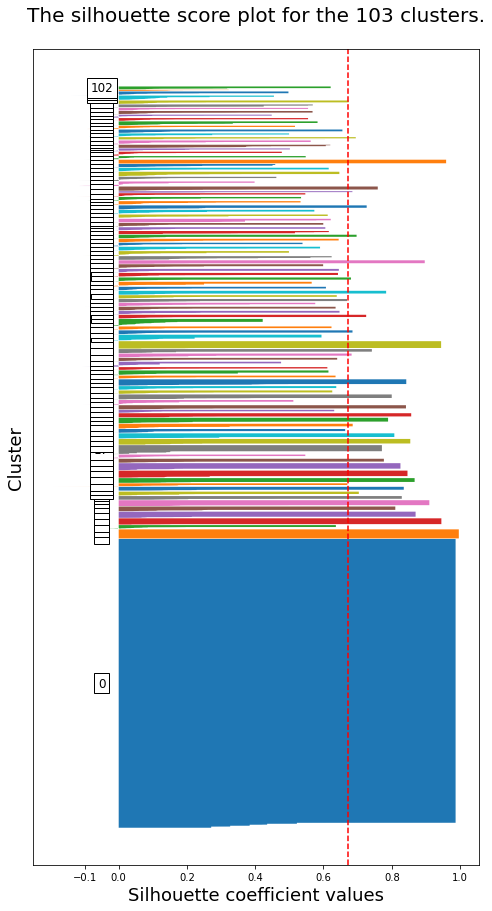

In [21]:
def plot_silhouette_samples(X, pred_labels):
  n_clusters = len(np.unique(pred_labels))

  fig, (ax) = plt.subplots(1, 1, figsize=(8,15))
  

  silhouette_avg = silhouette_score(X, pred_labels)
  sample_silhouette_values = silhouette_samples(X, pred_labels)

  y_lower = 10
  for i in range(n_clusters):
    ith_cluster_silhouette_values = sample_silhouette_values[pred_labels == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
  
    ax.fill_betweenx(np.arange(y_lower, y_upper), 
                     0, ith_cluster_silhouette_values)
    ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i),
            ha='center', va='center', fontsize=12,
            bbox={'boxstyle':'square',
                  'facecolor':'white'})
    y_lower = y_upper + 10
  
  ax.set_title(f"The silhouette score plot for the {n_clusters} clusters.\n",fontsize=20)
  ax.set_xlabel("Silhouette coefficient values",fontsize=18)
  ax.set_ylabel("Cluster",fontsize=18)
  ax.axvline(x=silhouette_avg, color="red", linestyle="--")
  ax.set_yticks([])
  ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

  return ax

plot_silhouette_samples(data_pca, y)

**Now let's see some visuals to see the most important words in every cluster**

In [22]:
#Let's see
def most_important_words(data_tfidf, y, topn=10):

  n_clusters = len(np.unique(y))
  result = []
  for i in range(n_clusters):
    ith_cluter_word_sum = np.mean(data_tfidf[np.argwhere(y==i).flatten()], axis=0)
    
    word_ids = np.array(np.argsort( ith_cluter_word_sum )[0, -topn:])
    word_ids = word_ids.reshape(-1)
    result = result + [(i, id, ith_cluter_word_sum[0, id]) for id in word_ids]

  return result

In [23]:
word_cluster_df = pd.DataFrame(most_important_words(data_tfidf, y, topn=5), columns=["Cluster", "WordId", "Score"])
word_cluster_df["Word"] = word_cluster_df["WordId"].apply(lambda id: tfidf_vec.get_feature_names()[id])
word_cluster_df = word_cluster_df.sort_values("Score", ascending=False)
word_cluster_df.head()

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,Cluster,WordId,Score,Word
9,1,49,0.997765,help
409,81,38,0.977891,first
194,38,78,0.976859,project
19,3,103,0.972471,world
284,56,28,0.961217,de


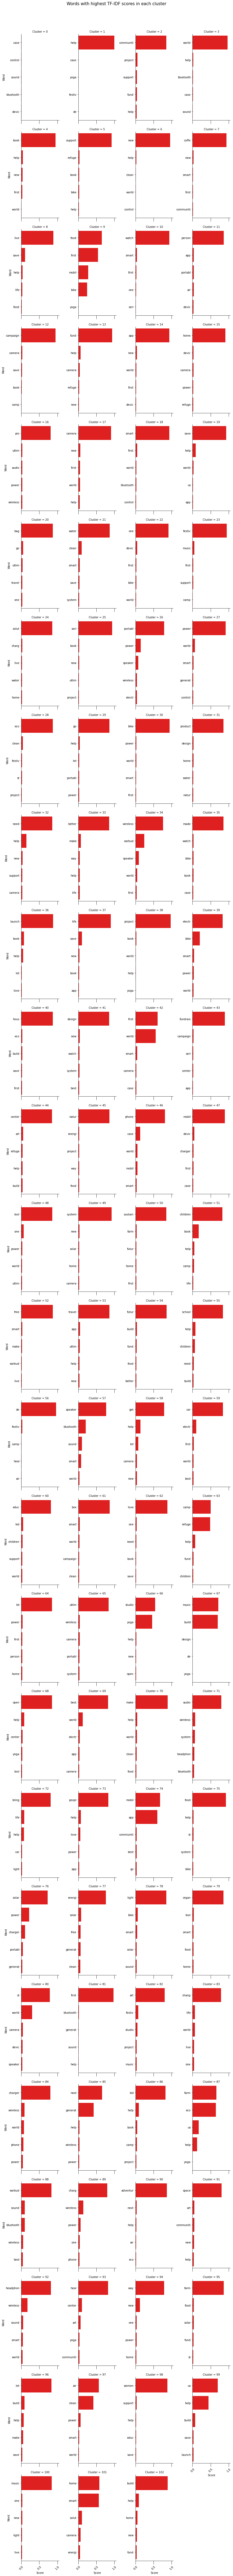

In [24]:
g = sns.catplot(x="Score", y="Word", col="Cluster", data=word_cluster_df, 
                sharey=False, col_wrap=4, kind="bar",
                color = 'red', aspect=.6)
[ax.tick_params(axis='x', rotation=45, size=13) for ax in g.axes.flatten()]
g.fig.suptitle("Words with highest TF-IDF scores in each cluster", y = 1.01, fontsize=15)
plt.show()

# **Thank you for your reading!**